# Assignment 2

**Assignment 2: Sampling**

**Goal**: ​​Get familiar with sampling methods by implementing these methods and applying them to a given probability distribution.

In this assignment we are going to learn about sampling methods. The goal is to implement *Metropolis-Hastings** (MH) algorithm and **Simulated Annealing** (SA) algorithm and analyze their behavior. Importantly, we aim at noticing differences between these two methods.

Here, we are interested in ​**sampling**​ from a mixture of two Gaussians, namely:

$$
p(\mathbf{x}) = 0.25\cdot \mathcal{N}\left(\mu = \begin{bmatrix} 2 \\ 2 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0.5 \\ 0.5 & 1 \end{bmatrix} \right) + 0.75\cdot \mathcal{N}\left(\mu = \begin{bmatrix} -3 \\ -3 \end{bmatrix}, \Sigma = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}\right)
$$

In this assignemnt, you are asked to implement:
1. The Metropolis-Hastings (MH) algorithm.
2. The simulated annealing (SA) algorithm.

After implementing both methods, please run experiments and compare both methods. Please follow all instructions.

## 1. Understanding the probability distribution

Please run the code below and visualize the probability distribution. Please try to understand this distribution, what the modes are (you can do it by inspecting the plot). What are possible problems here?

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

EPS = 1.e-7

In [2]:
# PLEASE DO NOT REMOVE!
# The definition of the probability distribution.
mv1 = multivariate_normal(mean=[2.,2.], cov=[[1., 0.5],[0.5, 1.]])
mv2 = multivariate_normal(mean=[-3.,-3.], cov=[[1., 0.],[0., 1.]])

def prob(x):
    return 0.25 * mv1.pdf(x) + 0.75 * mv2.pdf(x)

In [3]:
# PLEASE DO NOT REMOVE!
# Calculating the probability distribution.
def calculate_p(x1, x2):
    p_x = []
    for i in range(len(x1)):
        for j in range(len(x2)):
            p_x.append(prob(np.asarray([[x1[i], x2[j]]])))
    
    return np.asarray(p_x).reshape(len(x1), len(x2))

In [4]:
# PLEASE DO NOT REMOVE!
# Define coordinates
x1 = np.linspace(-10., 10., 400)
x2 = np.linspace(-10., 10., 400)

# Calculate the objective
p_x = calculate_p(x1, x2).reshape(len(x1), len(x2))

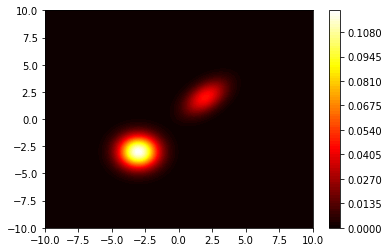

In [5]:
# PLEASE DO NOT REMOVE!
# Plot the objective
plt.contourf(x1, x2, p_x, 100, cmap='hot')
plt.colorbar()

**Question 1 (0-0.5pt):** How many modes do we have and what are they? What is the most probable point?

**Answer:**
<em>There are two modes here. The peak of the first is at coordinate (2, 2). The peak of the second one is at coordinate (-3, -3). The most probable point is the peak of the second mode at (-3, -3) as that mode is weighed 3 times higher or in other words is 3 times more probable.</em>

## 2. The Metropolis-Hastings algorithm

First, you are asked to implement the Metropolis-Hastings (MH) algorithm. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

NOTE: To implement the MH algorithm, you need to specify the proposal distribution.

**Question 2 (0-0.5pt):** What is the proposal distribution, $q(\mathbf{x}_{new} | \mathbf{x}_{old})$, in your case?

**Answer:**
<em>The proposal distribution is a normal distribution with the mean at $x_t$. It looks like $q(x|x_t) = \mathcal{N}(x|x_t, \Sigma)$.</em>

**Question 3 (0-0.5pt):** Is your proposal a proper proposal distribution? (That is, it must fulfill irreducibility and aperiodicity, see Andrieu et al., "An Introduction to MCMC for Machine Learning".)

**Answer:**
<em>It is a proper proposal distribution because despite having a lower likelihood the further away from the mean a point is, it never becomes zero and so all states are reachable and thus irreducibility is satisfied. Furthermore, aperiodicity is maintained because the points are selected at random. Mode collapse can happen if covariance is too low but this is still not periodic.</em>

In [6]:
#=========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
#=========
# Implement the Metropolis Hastings (MH) algorithm.
# It might be you use another arguments beside standard deviation (std).
# Please add them then. 

class MetropolisHastings(object):
    def __init__(self, x, prob, std=0.01):
        self.notprob = prob
        self.std = std
        self.variance = np.array([[std, 0],
                                  [0, std]])
        self.x_old = x

    def proposal(self, x):
        # Return a point sampled from the multivariate distribution around the old point
        return np.random.multivariate_normal(x, self.variance)

    def evaluate(self, x_new, x_old):
        # Find the differetent probabilties and calculate the acceptance value
        new_given_old = multivariate_normal.pdf(x_new, mean=x_old, cov=self.variance)
        old_given_new = multivariate_normal.pdf(x_old, mean=x_new, cov=self.variance)
        A = prob(x_new)/prob(x_old)*old_given_new/new_given_old
        return np.minimum(1., A)
  
    def select(self, x_new, A):
        # Return the new x if the acceptance probability exceeds a random number
        return x_new if A > np.random.rand() else self.x_old

    def step(self):
        # 0. Reshape data for calculations
        x = self.x_old.reshape(-1)
        # 1. Proposal
        x_prop = self.proposal(x)
        # 2. Evaluate
        A = self.evaluate(x_prop, x)
        # 3. Select
        x_new = self.select(x_prop, A).reshape(1, -1)
        # Lastly, save the new value
        self.x_old = x_new
        return x_new

In [7]:
# PLEASE DO NOT REMOVE!
# An auxiliary function for plotting.
def plot_sampling_process(ax, sampler, title):
    # Plot the objective function
    ax.contourf(x1, x2, p_x/p_x.sum(), 100, cmap='hot')

    # Init the solution
    x_samp = sampler.x_old
    # Run the optimization algorithm
    count = 0 # we calculate how many of new candidates were accepted
    for i in range(num_epochs):
        x = sampler.step()

        if (x == x_samp[-1]).all():
            pass
        else:
            count = count + 1
            x_samp = np.concatenate((x_samp, x),0)

    ax.scatter(x_samp[:,0], x_samp[:,1], marker='+', s=1, alpha=0.5)
    # We add AR (Acceptance Rate) to the title.
    ax.set_title(title + ' AR={:.2f}'.format(count/num_epochs))

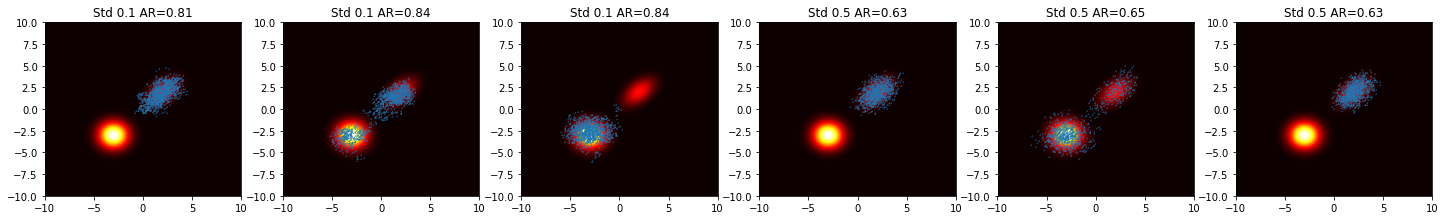

In [8]:
# PLEASE DO NOT REMOVE!
# Running the MH algorithm with different step sizes
num_epochs = 1500 # the number of epochs
stds = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5] # we repeat experiments 3 times per std

# plotting the convergence of the MH
fig_mh, axs = plt.subplots(1,len(stds),figsize=(20, 3))
fig_mh.tight_layout()

x_init = np.asarray([[0., 0.]])

for i, std in enumerate(stds):
    # init the MH
    mh = MetropolisHastings(x=x_init, prob=p_x, std=std)
    # plot the convergence
    plot_sampling_process(axs[i], sampler=mh, title='Std ' + str(mh.std))

**Question 4 (0-0.5)**: Please comment on the behavior of the MH for different values of the standard deviation. Is it always possible to sample from both modes?

**Answer**: <em>The Metropolis-Hastings algorithm works by first generating a point from the proposal distribution then finding the acceptance rate and finally making a decision if this new point should be included in the sample. It manifests as a random walk where each new point is dependent on the last. It is always possible to sample from both modes. If it weren't irreducability would not be satisfied. I tested this with a far greater number of epochs and both modes were always sampled from. For the larger value of the standard deviation, mode collapse is not as common as it is for the smaller deviation albeit not always circumvented either.</em>

**Question 5 (0-0.5)**: Please comment on the acceptance ratio (AR) for std=0.1 and std=0.5. How can you explain the difference?

**Answer**: <em>The AR for std=0.1 is around 0.83 and around 0.65 for std=0.5. The reason for a greater AR with the lower standard deviation can likely be attributed to the fact that points are usually generated closer to $x_t$ and less frequently outside of the estimated distribution where most of the rejection happens.</em>

## 3. The simulated annealing (SA) sampling

In the second part of this assignment, you are asked to implement the Simulated Annealing (SA) algorithm with cooling scheme as dicussed during the lecture.

**Question 6 (0-0.5pt)**: Please explain what is the difference between MH and SA?

**Answer**: <em>Simulated annealing has an extra attribute, temperature, which decreases with time. While temperature is high, the algorithm is more likely to accept a new point.</em>

**Question 7 (0-0.5pt)**: Why is SA sometimes more preferrable than MH? Which of these two methods would you use for optimization (not sampling)?

**Answer**: <em>Simulated annealing is preferable when you want to find the optimal solution as it is likelier to get out of local minima because of the high initial temperature. For this reason it is preferable to Metropolis-Hastings in optimization.</em>

In [9]:
#=========
# GRADING:
# 0
# 0.5pt if properly implemented but badly commented
# 1.0 pt if properly implemented and clear
# NOTE: The cooling scheme must be properly implemented!
#=========
# Implement the Simulated Annealing (SA) algorithm. 
# It is equivalent to implementing the step function.
class SimulatedAnnealing(object):
    def __init__(self, x, prob, std=0.1, T0=1., C=1.):
        self.prob = prob
        self.std = std
        self.variance = np.array([[std, 0],
                                  [0, std]])
        self.x_old = x
        self.T = T0
        self.C = C
        self.t = 0 # we init the step number to 0; we need it for cooling scheme

    def proposal(self, x):
        # Return a point sampled from the multivariate distribution around the old point
        return np.random.multivariate_normal(x, self.variance)

    def evaluate(self, x_new, x_old, T):
        # Find the differetent probabilties and calculate the acceptance value
        new_given_old = multivariate_normal.pdf(x_new, mean=x_old, cov=self.variance)
        old_given_new = multivariate_normal.pdf(x_old, mean=x_new, cov=self.variance)
        A = (prob(x_new)/prob(x_old))**(1/T)*old_given_new/new_given_old
        return np.minimum(1., A)
  
    def select(self, x_new, A):
        # Return the new x if the acceptance probability exceeds a random number
        return x_new if A > np.random.rand() else self.x_old

    def step(self):
        # 0. Reshape data for calculations
        x = self.x_old.reshape(-1)
        # 1. Proposal
        x_prop = self.proposal(x)
        # 2. Evaluate
        A = self.evaluate(x_prop, x, self.T)
        # 3. Select
        x_new = self.select(x_prop, A).reshape(1, -1)
        # 4. Cooling
        self.t += 1
        self.T *= .999999**(self.t*self.C)
        # Lastly, save the new value
        self.x_old = x_new
        return x_new

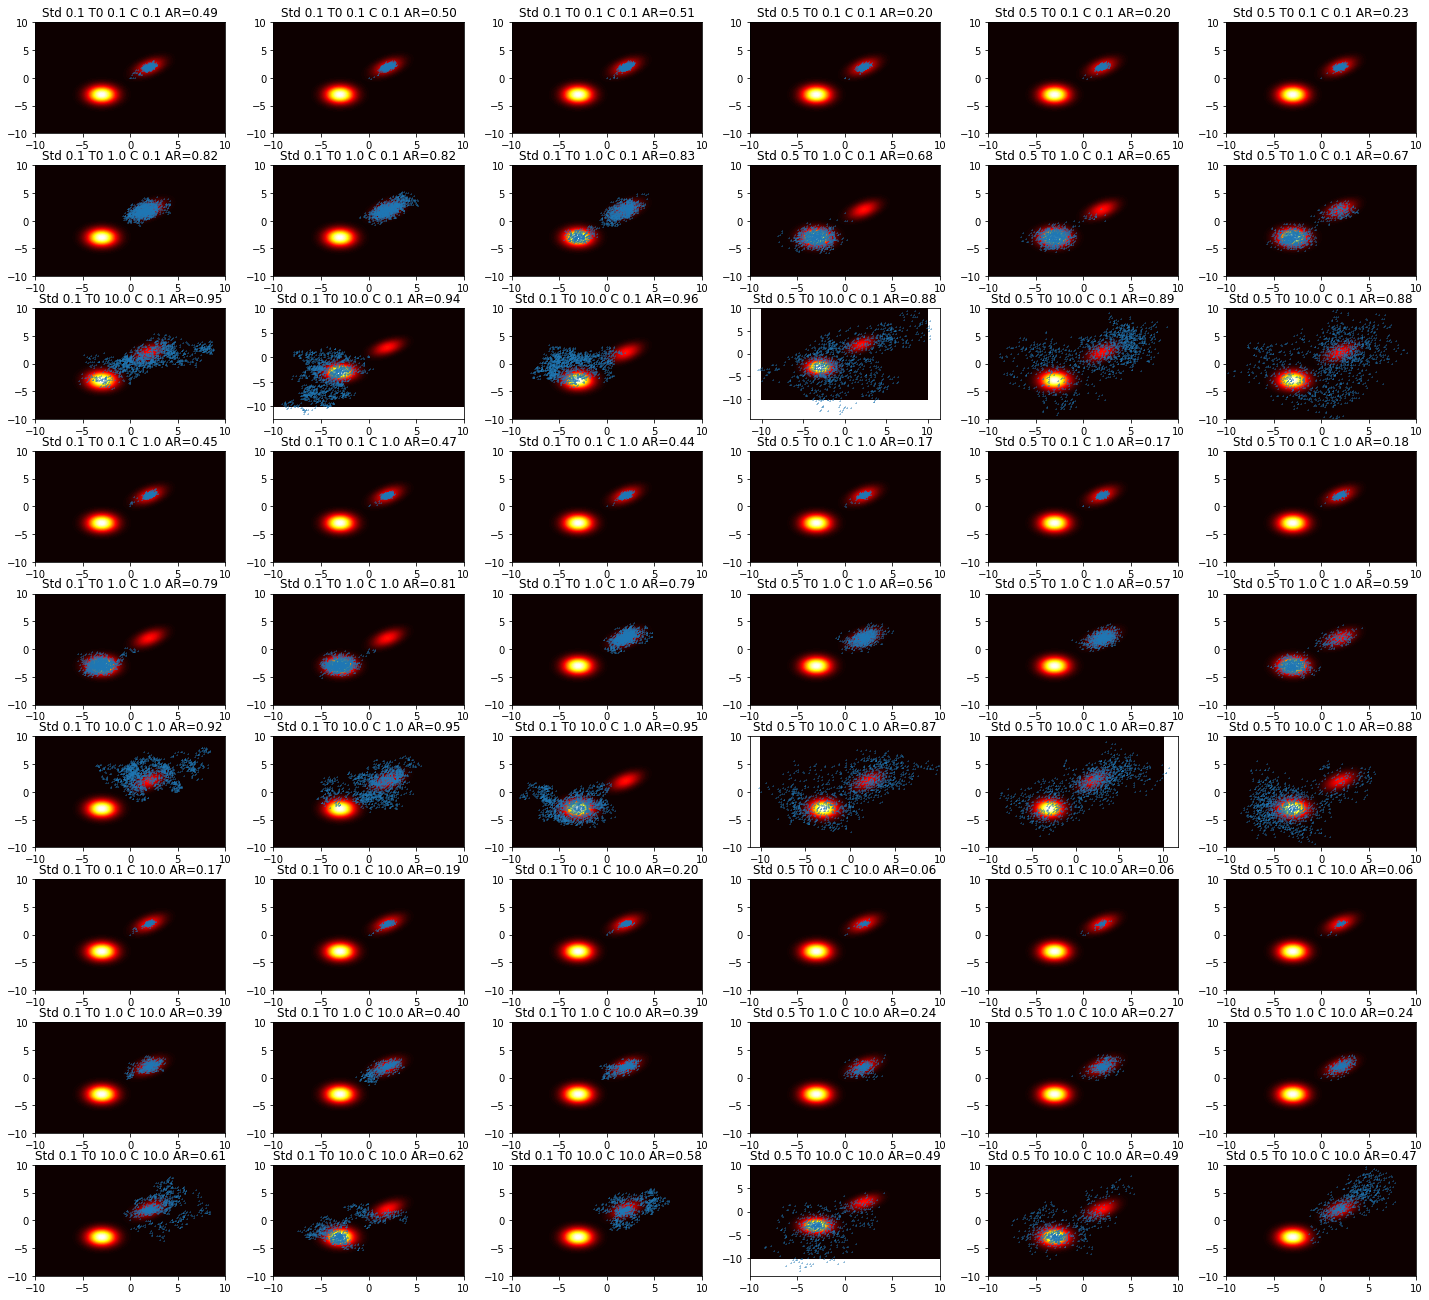

In [10]:
# PLEASE DO NOT REMOVE!
# Running the SA algorithm with different step sizes
num_epochs = 1500 # the number of epochs
stds_sa = [0.1, 0.1, 0.1, 0.5, 0.5, 0.5] # values of std; notice we repeat them due to randomness
T0s = [0.1, 1., 10.] # values of T0
Cs = [.1, 1., 10.] # values of C

# plotting the convergence of the MH
fig_sa, axs = plt.subplots(len(Cs) * len(T0s),len(stds_sa),figsize=(20, 18))
fig_sa.tight_layout()

# Always start with the same point
x_init = np.asarray([[0., 0.]])
# START SA
for i in range(len(Cs)):
    # Take a value for C
    C = Cs[i]
    for k in range(len(T0s)):
        # Take a value for the init temperature T0
        T0 = T0s[k]
        for j in range(len(stds_sa)):
            # take the std
            std = stds_sa[j]
            # init the SA
            sa = SimulatedAnnealing(x=x_init, prob=p_x, std=std, T0=T0, C=C)
            # plot the sampling process
            plot_sampling_process(axs[len(T0s)*i+k,j], sampler=sa, title='Std ' + str(sa.std) + ' T0 ' + str(T0) + ' C ' + str(C))

**Question 8 (0-0.5pt)** How does the standard deviation influence the SA?

**Answer:** <em>The value of the standard deviation influences how far the points are generated. For the larger value of it, it is visible, especially where the temperature starts as high, that the points are generated in a larger radius and are more spread out as opposed to clustering together which can be seen with the lower standard deviation.</em>

**Question 9 (0-0.5pt)** How does the initial temperature, $T_0$, influence the SA?

**Answer:** <em>The higher the initial temperature, the more points are going to be far away from the high probability densities. This allows for the algorithm to escape local minima and it can be seen that in the examples with low initial temperature, only the lower minimum is found and the global minimus is never visited. In contrast, the plots with greater initial temperature often reach the global minimum. It's hard to say if they stay there but because of the cooling it is likely.</em>

**Question 10 (0-0.5pt)** How does the constant $C$ influence the SA?

**Answer:** <em>The greater the constant $C$ is, the faster cooling happens and the less time the algorithm has to escape the local minima. On the other hand, cooling helps not to leap out of the global minimum. It is clearly visible in the figures that the larger cooling rates are not as efficient at finding the global minimum as the lower one.</em>

**Question 11 (0-0.5pt)** Which setting (i.e., std, $T_0$, $C$) did perform the best in terms of sampling?

**Answer:** <em>It is tough to say exactly as the algorithm is stochastic and varies with each run but elementary observations show that when std $=0.5$, $T_0=1$, and $C=0.1$, the results are often satisfactory and the global minimum is reached.</em>

**Question 12 (0-0.5pt)** How do different values of the hyperparameters (i.e., std, $T_0$, $C$) influence the acceptance ratio (AR)? Why?

**Answer:** <em>The initial temperature affects the acceptance rate postiviely such that the higher the initial temperature, the higher the acceptance rate. This is because while the temperature is high, the acceptance probability is higher. The standard deviation and the cooling constant work inversely. That is to say that, the higher the standard deviation and/or cooling factor, the lower the acceptance rate. The standard deviation here influences the algorithm the same way as in Metropolis-Hastings. The cooling factor slows down the exploration of the state space and therefore the larger it is the sooner the algorithm starts generating low acceptance rates.</em>

## 4. Final remarks: MH vs. SA

Eventually, please answer the following last questions that will allow you to conclude the assignment and draw conclusions.

**Question 13 (0-0.5-1pt)**: Which of the two algorithms did perform better? Why?

**Answer**: <em>These algorithms accomplish different tasks so comparing their performance is like comparing apples to oranges. The MH algorithm collects a far more representative sample of the original distribution. The SA algorithm more often gets to the global optimum which makes it perform better in problem solving but not sampling.</em>

**Question 14 (0-0.5-1pt)**: Which of the two algorithms is easier to use? Why?

**Answer**: <em>The easier to implement and use is the MH algorithm because it is simpler. It doesn't have the temperature hyperparameter and does not require the implementation of a cooling system which add complexity and more trial and error to find acceptable values.</em>